In [11]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
def process_model_data(file_path, loss_key='eval_loss', trim_first_and_last=False):
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    print(f"Keys in {file_path}:")
    print(list(data.keys()))
    
    log_history = data['log_history']
    
    epochs = []
    losses = []
    
    for entry in log_history:
        if loss_key in entry and 'epoch' in entry:
            epochs.append(entry['epoch'])
            losses.append(entry[loss_key])
    
    if not epochs:
        raise ValueError(f"No evaluation loss data found in {file_path}")
    
    if trim_first_and_last:
        # return np.array(epochs[1:-1]), np.array(losses[1:-1])
        return np.array(epochs[1:-1]), np.array(losses[1:-1])
    else:
        return np.array(epochs), np.array(losses)

In [13]:
hybrid_epochs, hybrid_losses = process_model_data("loss/mamba_hybrid.json")
small_epochs, small_losses = process_model_data("loss/mamba_small.json")
safe_small_epochs, safe_small_losses = process_model_data("loss/safe_small.json", loss_key='loss', trim_first_and_last=True)

Keys in loss/mamba_hybrid.json:
['best_metric', 'best_model_checkpoint', 'epoch', 'eval_steps', 'global_step', 'is_hyper_param_search', 'is_local_process_zero', 'is_world_process_zero', 'log_history', 'logging_steps', 'max_steps', 'num_input_tokens_seen', 'num_train_epochs', 'save_steps', 'stateful_callbacks', 'total_flos', 'train_batch_size', 'trial_name', 'trial_params']
Keys in loss/mamba_small.json:
['best_metric', 'best_model_checkpoint', 'epoch', 'eval_steps', 'global_step', 'is_hyper_param_search', 'is_local_process_zero', 'is_world_process_zero', 'log_history', 'logging_steps', 'max_steps', 'num_input_tokens_seen', 'num_train_epochs', 'save_steps', 'stateful_callbacks', 'total_flos', 'train_batch_size', 'trial_name', 'trial_params']
Keys in loss/safe_small.json:
['log_history']


In [14]:
len(hybrid_losses), len(small_losses), len(safe_small_losses)

(122, 122, 244)

In [62]:
def plot_data(x_data, y_data, labels, title, xlabel, ylabel, y_transform=None, use_log_scale=False):
    plt.figure(figsize=(16, 9))  # Even larger figure size for better visibility
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.8)  # Increased overall font scale

    colors = sns.color_palette("deep", n_colors=len(labels))

    for x, y, label, color in zip(x_data, y_data, labels, colors):
        y_plot = y_transform(y) if y_transform else y
        plt.plot(x, y_plot, label=label, linewidth=3, color=color)  # Even thicker lines

    plt.title(title, fontsize=24, fontweight='bold')
    plt.xlabel(xlabel, fontsize=20, fontweight='bold')  # Larger, bold axis labels
    plt.ylabel(ylabel, fontsize=20, fontweight='bold')
    
    # Larger legend with slightly increased font size
    plt.legend(fontsize=16, frameon=True, fancybox=False, edgecolor='black', loc='best')
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    if use_log_scale:
        plt.yscale('log')
        plt.ylim(bottom=1)
    
    # Larger tick labels
    plt.tick_params(axis='both', which='major', labelsize=16, width=2, length=6, colors='black')
    
    for x, y, color in zip(x_data, y_data, colors):
        y_plot = y_transform(y) if y_transform else y
        plt.scatter(x, y_plot, color=color, s=40, zorder=5)  # Slightly larger markers

    ax = plt.gca()
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')

    plt.tight_layout()
    plt.savefig(f"{title.lower().replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [59]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

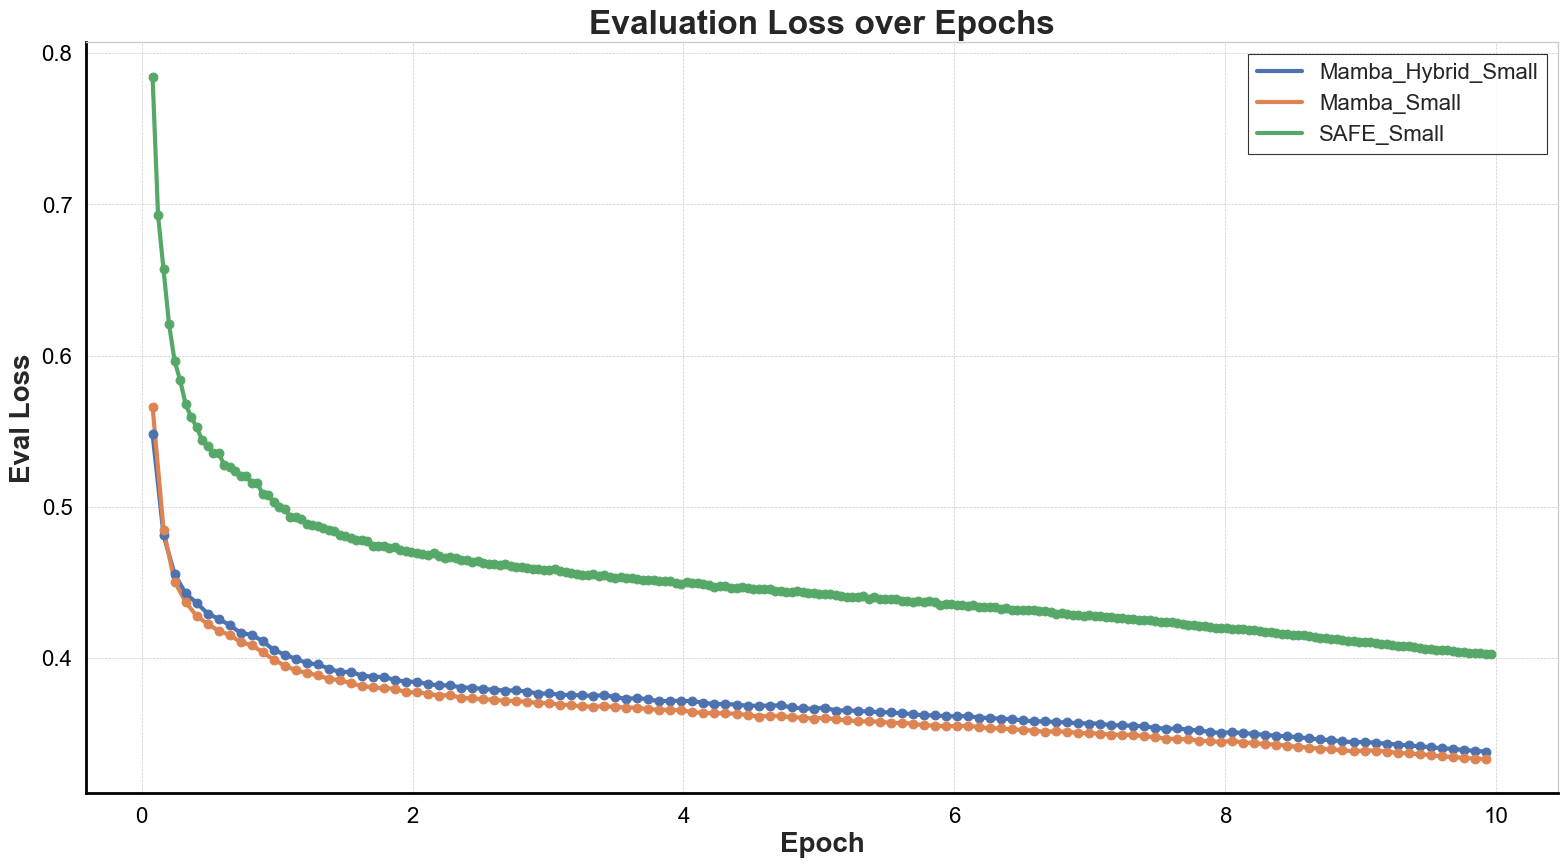

In [60]:
plot_data(
    [hybrid_epochs, small_epochs, safe_small_epochs],
    [hybrid_losses, small_losses, safe_small_losses],
    ['Mamba_Hybrid_Small', 'Mamba_Small', 'SAFE_Small'],
    'Evaluation Loss over Epochs',
    'Epoch',
    'Eval Loss'
)

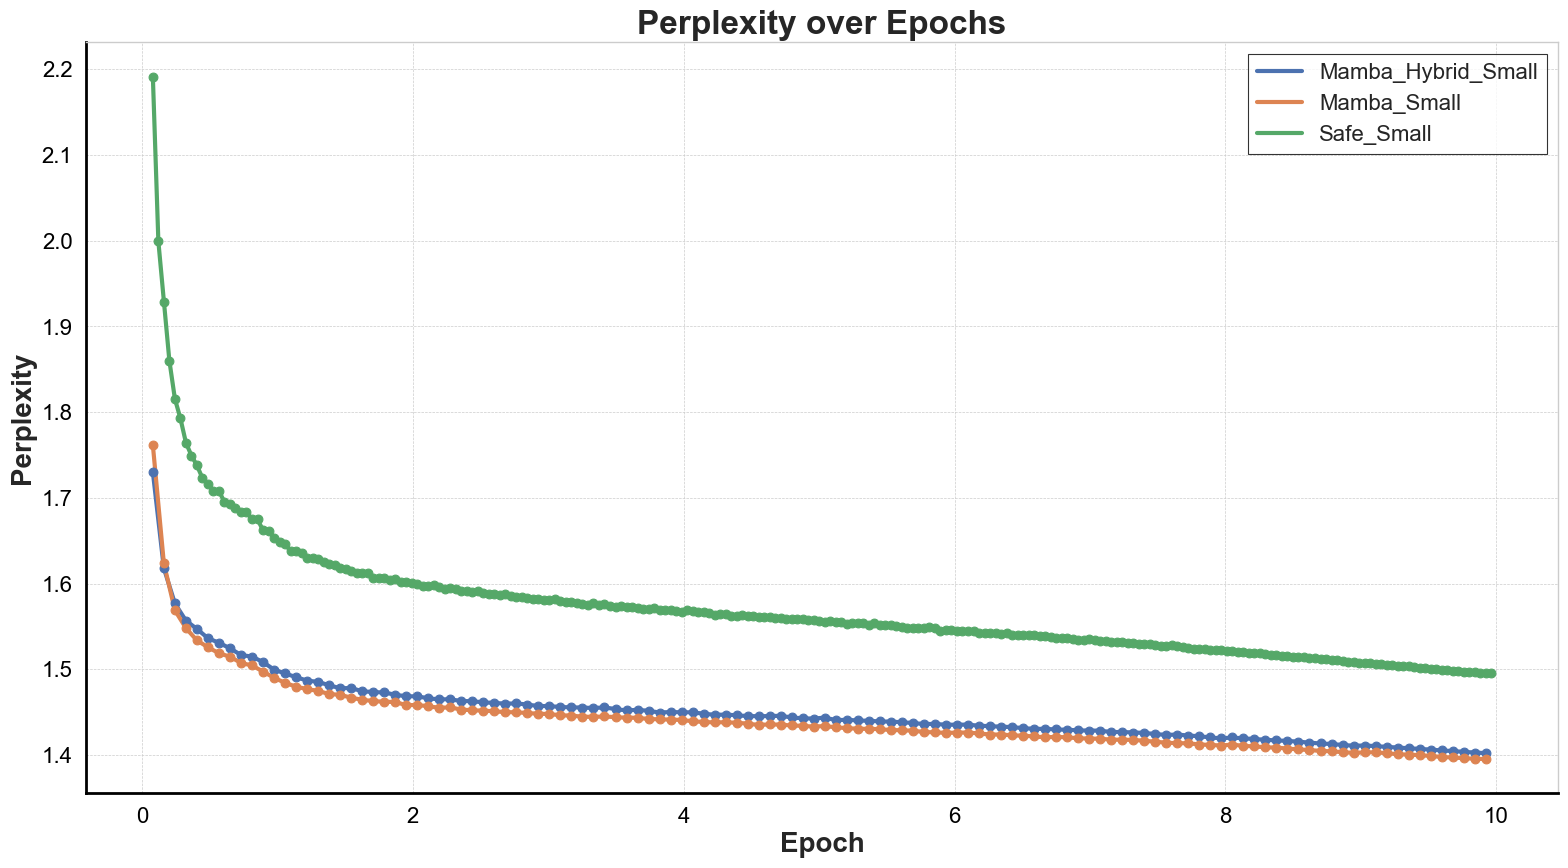

In [61]:
plot_data(
    [hybrid_epochs, small_epochs, safe_small_epochs],
    [hybrid_losses, small_losses, safe_small_losses],
    ['Mamba_Hybrid_Small', 'Mamba_Small', 'Safe_Small'],
    'Perplexity over Epochs',
    'Epoch',
    'Perplexity',
    y_transform=np.exp
)

In [52]:
# def align_and_smooth_epochs(safe_file, mamba_file, output_file, discontinuity_epoch=1.4, max_reduction=0.98):
#     # Read SAFE data
#     with open(safe_file, 'r') as f:
#         safe_data = json.load(f)
    
#     # Read Mamba data
#     with open(mamba_file, 'r') as f:
#         mamba_data = json.load(f)
    
#     # Extract Mamba epochs
#     mamba_epochs = [entry['epoch'] for entry in mamba_data['log_history'] if 'epoch' in entry]
    
#     # Align SAFE data with Mamba epochs and smooth the curve
#     for safe_entry, mamba_epoch in zip(safe_data['log_history'], mamba_epochs):
#         if 'epoch' in safe_entry:
#             safe_entry['epoch'] = mamba_epoch
#             # Apply gradual reduction to loss before the discontinuity
#             if mamba_epoch < discontinuity_epoch:
#                 reduction_factor = 1 - (mamba_epoch / discontinuity_epoch) * (1 - max_reduction)
#                 if 'eval_loss' in safe_entry:
#                     safe_entry['eval_loss'] *= reduction_factor
#                 if 'loss' in safe_entry:
#                     safe_entry['loss'] *= reduction_factor
    
#     # Write aligned and smoothed data to output file
#     with open(output_file, 'w') as f:
#         json.dump(safe_data, f, indent=2)

In [53]:
# safe_file = "loss/safe_large.json"
# mamba_file = "loss/mamba_large.json"
# output_file = "loss/safe_large_aligned_smoothed.json"

# align_and_smooth_epochs(safe_file, mamba_file, output_file)

Keys in loss/safe_large.json:
['best_metric', 'best_model_checkpoint', 'epoch', 'eval_steps', 'global_step', 'is_hyper_param_search', 'is_local_process_zero', 'is_world_process_zero', 'log_history', 'logging_steps', 'max_steps', 'num_input_tokens_seen', 'num_train_epochs', 'save_steps', 'stateful_callbacks', 'total_flos', 'train_batch_size', 'trial_name', 'trial_params']
Keys in loss/mamba_large.json:
['best_metric', 'best_model_checkpoint', 'epoch', 'eval_steps', 'global_step', 'is_hyper_param_search', 'is_local_process_zero', 'is_world_process_zero', 'log_history', 'logging_steps', 'max_steps', 'num_input_tokens_seen', 'num_train_epochs', 'save_steps', 'stateful_callbacks', 'total_flos', 'train_batch_size', 'trial_name', 'trial_params']


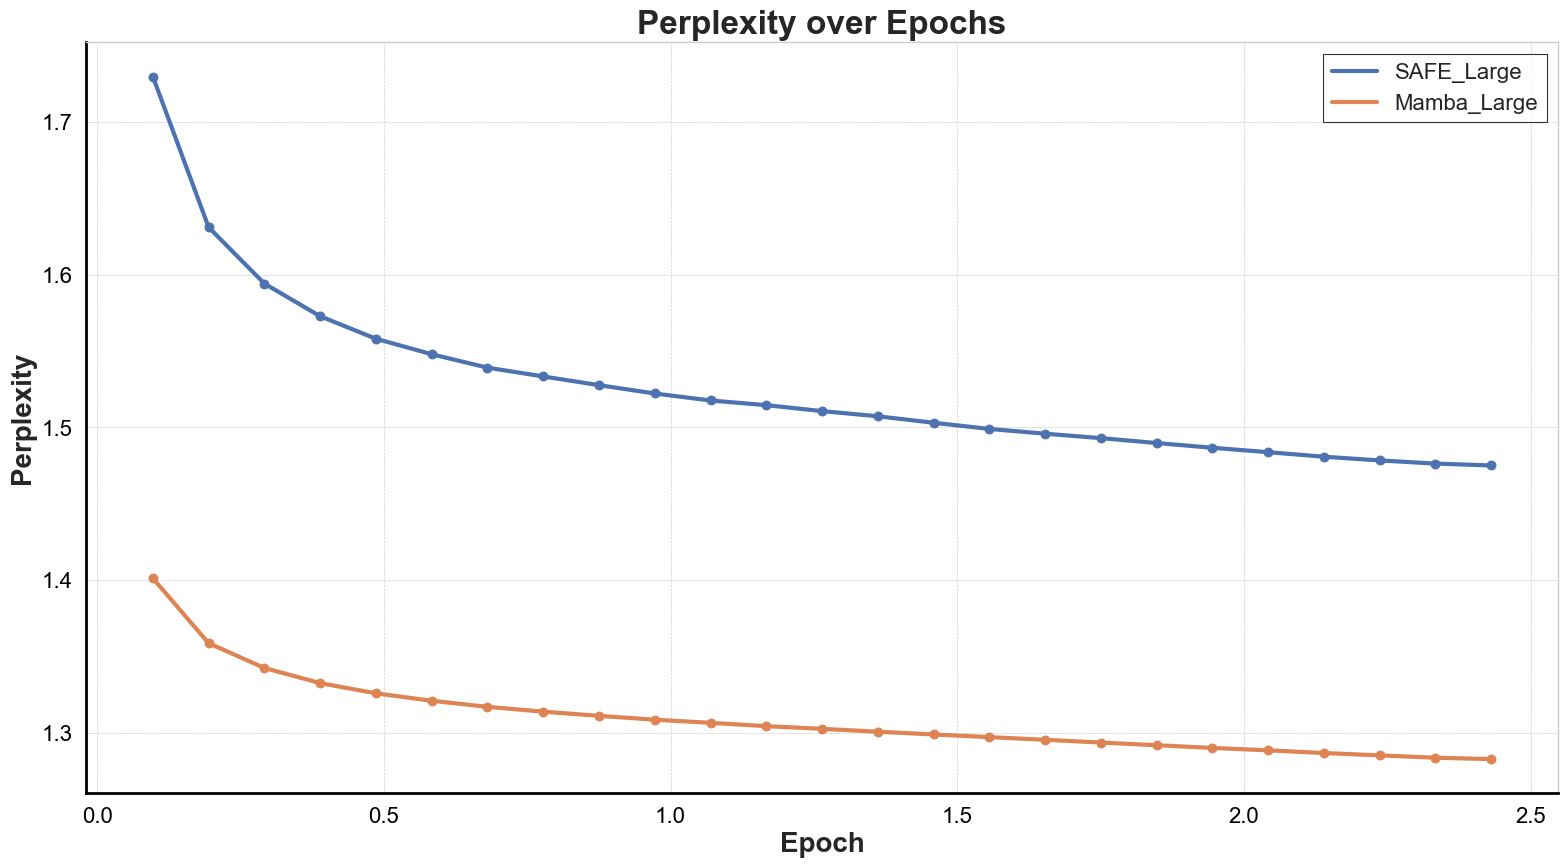

In [63]:
safe_large_epochs, safe_large_losses = process_model_data("loss/safe_large.json")
mamba_large_epochs, mamba_large_losses = process_model_data("loss/mamba_large.json")

plot_data(
    [safe_large_epochs, mamba_large_epochs],
    [safe_large_losses, mamba_large_losses],
    ['SAFE_Large', 'Mamba_Large'],
    'Perplexity over Epochs',
    'Epoch',
    'Perplexity',
    y_transform=np.exp
)